In [258]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas import read_csv

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

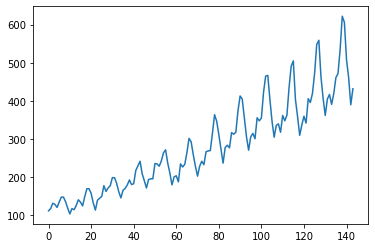

In [259]:
dataframe = read_csv("data/AirPassengers.csv", usecols=[1])
plt.plot(dataframe)

In [260]:
#Convert pands dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32')

In [261]:
#normalize data
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [262]:
#split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [263]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    
    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:(i + seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x), np.array(y)


In [264]:
seq_size = 5 # number of time steps to look back
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test,seq_size)

In [265]:
#Reshape input to be [samples, time steps, features]

#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#print('Single LSTM with hidden Dense...')
#model = Sequential()
#model.add(LSTM(64, input_shape=(None, seq_size)))
#model.add(Dense(32))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.summary()

In [266]:
#Stacked LSTM with 1 hidden dense layer

#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#model = Sequential()
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
#model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.summary()

In [267]:
#Bidirection LSTM

#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(None, seq_size))))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')


In [269]:
#ConvLSTM

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, activation='relu', kernel_size=(1,1)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [270]:
model.fit(trainX, trainY, validation_data=(testX, testY),
         verbose=2, epochs=100)

Epoch 1/100
3/3 - 2s - loss: 0.0613 - val_loss: 0.3133 - 2s/epoch - 688ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0470 - val_loss: 0.2603 - 27ms/epoch - 9ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0346 - val_loss: 0.2114 - 32ms/epoch - 11ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0248 - val_loss: 0.1668 - 31ms/epoch - 10ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0175 - val_loss: 0.1273 - 32ms/epoch - 11ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0130 - val_loss: 0.0944 - 33ms/epoch - 11ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0108 - val_loss: 0.0703 - 36ms/epoch - 12ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0107 - val_loss: 0.0548 - 39ms/epoch - 13ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0114 - val_loss: 0.0469 - 35ms/epoch - 12ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0117 - val_loss: 0.0448 - 33ms/epoch - 11ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0112 - val_loss: 0.0459 - 32ms/epoch - 11ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0103 - val_loss: 0.0495 - 32ms/epoch - 11ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0095 - 

In [271]:
# Prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 2ms/step


In [272]:
# Estimate model performance by doing inverse transformation

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [273]:
#calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test score: %.2f RMSE' % (testScore))

Train score: 24.37 RMSE
Test score: 51.78 RMSE


In [274]:
#align the prediction on the x-axis with the origin
#shift train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [275]:
#shift test predictions for plotting

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size * 2)+1: len(dataset)-1, :] = testPredict

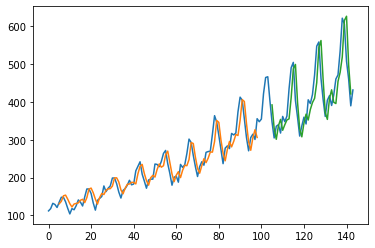

In [276]:
#plot baseline and prediction

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()